# Rooster：客戶行為與渠道效益分析 Notebook

本 Notebook 對應 A2 報告的分析流程，包含資料載入、清理、描述性分析與基礎預測建模。  
建議搭配文字報告一起閱讀：Notebook 著重「怎麼做」，報告負責說明「做了什麼」與「為什麼重要」。

## 0. 環境設定與套件安裝

在本機或 Colab 若尚未安裝套件，可以先在「終端機」或單獨一個 Code cell 執行下列指令；  
若環境已安裝好，可略過此步驟。

In [ ]:
pip install pycaret==3.3.2 pandas==2.1.4 seaborn==0.13.2 matplotlib==3.7.5 numpy==1.26.4 openpyxl==3.1.5

Note: you may need to restart the kernel to use updated packages.


## 1.2 載入套件與原始資料

讀取 `rooster_a2.xlsx` 中的四個工作表，並檢查基本結構。

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pycaret.classification import *

# 統一圖表風格（方便截圖貼到報告 / 投影片）
sns.set_theme(style="white", rc={"figure.figsize": (12, 6)})
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.0})

file_path = "rooster_a2.xlsx"  # 若路徑不同，請在此處修改

products   = pd.read_excel(file_path, sheet_name="products")
orders     = pd.read_excel(file_path, sheet_name="orders")
orderlines = pd.read_excel(file_path, sheet_name="orderlines")
customers  = pd.read_excel(file_path, sheet_name="customers")

shape_summary = pd.DataFrame({
    "Dataset": ["products", "orders", "orderlines", "customers"],
    "Rows":    [products.shape[0], orders.shape[0], orderlines.shape[0], customers.shape[0]],
    "Columns": [products.shape[1], orders.shape[1], orderlines.shape[1], customers.shape[1]],
})
shape_summary.index = shape_summary.index + 1

print("=== Dataset Shape Summary ===")
display(shape_summary)


=== Dataset Shape Summary ===


,Dataset,Rows,Columns
1,products,226,12
2,orders,10541,16
3,orderlines,27795,8
4,customers,8465,5


In [2]:
# 列出各資料集的欄位名稱，並編號以方便後續參考
def print_numbered_columns(df, name):
    print(f"=== {name} ===")
    for idx, col in enumerate(df.columns, start=1):
        print(f"{idx}. {col}")
    print("\n")

print_numbered_columns(orders, "orders")
print_numbered_columns(orderlines, "orderlines")
print_numbered_columns(products, "products")
print_numbered_columns(customers, "customers")

=== orders ===
1. order_number
2. customer_email
3. order_date
4. payment_method_title
5. shipping_method_title
6. coupon_code
7. coupon_count
8. origin
9. order_subtotal
10. order_total
11. order_total_tax
12. order_shipping
13. order_refund
14. cart_discount
15. discount_amount
16. discount_amount_tax


=== orderlines ===
1. order_number
2. product_id
3. variation_id
4. sku
5. line_id
6. qty_minus_refund
7. item_price
8. item_price_before_discount


=== products ===
1. product_id
2. range
3. product_type
4. category
5. product_name_main
6. product_name
7. size
8. variation_id
9. sku
10. price
11. type
12. colour


=== customers ===
1. billing_email
2. customer_first_order_date
3. customer_last_order_date
4. customer_total_orders
5. customer_total_spent




=== order_total 描述統計 ===


count    10541.00
mean        45.63
std         28.82
min          0.00
25%         20.80
50%         40.41
75%         55.20
max        304.20
Name: order_total, dtype: object

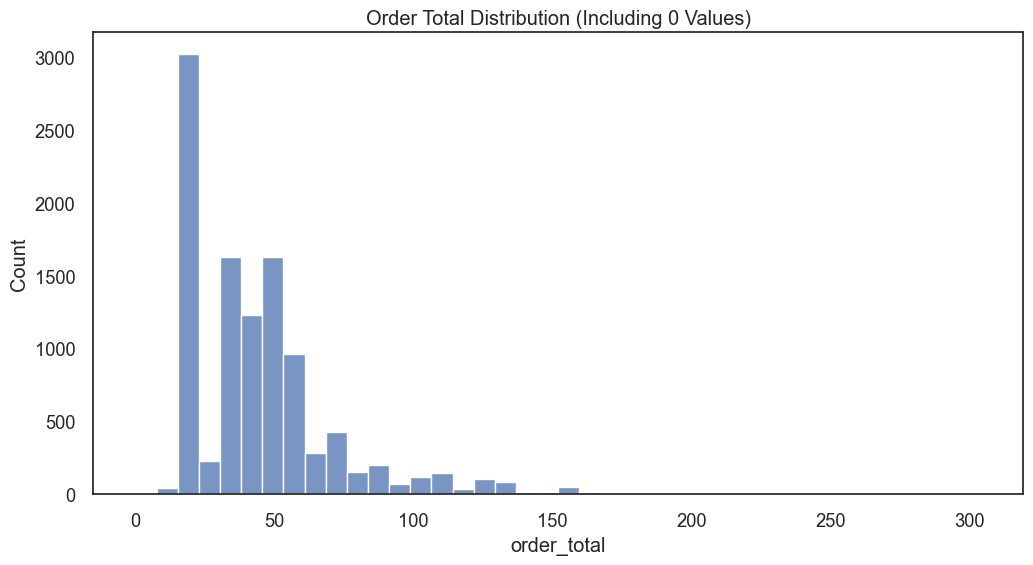

In [ ]:
# === 1.3.1 訂單金額描述統計與分布 ===
orders["order_total"] = pd.to_numeric(orders["order_total"], errors="coerce")
order_total_desc = orders["order_total"].describe()
print("=== order_total 描述統計 ===")
display(order_total_desc.map('{:.2f}'.format))

sns.histplot(data=orders, x="order_total", bins=40)
plt.title("Order Total Distribution (Including 0 Values)")
plt.xlabel("order_total")
plt.ylabel("Count")
plt.show()

## 1.4 數據品質檢查與清理

本節檢查：

- `order_total` 分布與極端值
- `order_total = 0` 是否需要排除
- `coupon_code` 的缺失比例與業務意義


In [4]:
# 檢查 order_total = 0 並建立清洗版 orders_clean
zero_orders = orders[orders["order_total"] == 0]
print(f"order_total = 0 的訂單筆數：{len(zero_orders)}")
display(zero_orders.head())

orders_clean = orders[orders["order_total"] > 0].copy()
orders_clean["coupon_used"] = orders_clean["coupon_code"].notna()
orders_clean["order_date"] = pd.to_datetime(orders_clean["order_date"])
print(f"清洗後訂單筆數：{len(orders_clean)}")

order_total = 0 的訂單筆數：8


,order_number,customer_email,order_date,payment_method_title,shipping_method_title,coupon_code,coupon_count,origin,order_subtotal,order_total,order_total_tax,order_shipping,order_refund,cart_discount,discount_amount,discount_amount_tax
6501,ord_470aefe4,eml_a5eff54f@gmail.example.net,2024-10-14 17:55,NaN,NaN,PROMO100,1,Google,83.33,0.0,0.0,0.0,0.0,83.333333,83.33,16.67
7246,ord_3fb41b2d,eml_7b6ccaae@gmail.example.net,2024-11-10 18:55,NaN,NaN,PROMO10,1,Direct,8.33,0.0,0.0,0.0,0.0,8.333333,8.33,1.67
7256,ord_18a79c76,eml_2c768f80@gmail.example.net,2024-11-10 21:48,NaN,NaN,VOUCHER10,1,Google,8.33,0.0,0.0,0.0,0.0,8.333333,8.33,1.67
7260,ord_13d46568,eml_1b3c1c7c@gmail.example.net,2024-11-10 23:25,NaN,Packet - Courier,PROMO100,1,Newsletter,12.42,0.0,0.0,0.0,0.0,12.416667,12.42,2.48
7267,ord_55182f9f,eml_2c768f80@gmail.example.net,2024-11-11 09:06,NaN,NaN,VOUCHER10,1,Google,8.33,0.0,0.0,0.0,0.0,8.333333,8.33,1.67


清洗後訂單筆數：10533


=== 優惠券欄位處理後預覽 ===


,order_number,coupon_code,coupon_used
0,ord_c1c3b332,NaN,False
1,ord_c377a279,NaN,False
2,ord_29e3b17c,NaN,False
3,ord_f98fce63,NaN,False
4,ord_877c03bc,NaN,False



=== 優惠券使用比例 ===


,proportion
coupon_used,
False,70.96%
True,29.04%


=== order_total 描述統計 ===


count    10541.00
mean        45.63
std         28.82
min          0.00
25%         20.80
50%         40.41
75%         55.20
max        304.20
Name: order_total, dtype: float64

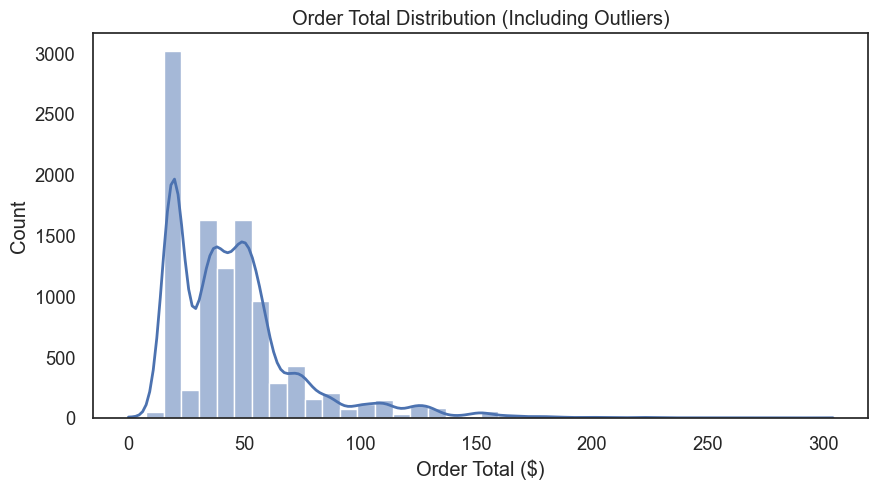

In [ ]:
# === 1.3.2 優惠券欄位缺失比例與重新編碼 ===
# 將 coupon_code 的空值邏輯轉換為 "coupon_used" (True/False)
orders["coupon_used"] = orders["coupon_code"].notna()

# 檢查結果 (顯示前 5 筆，讓讀者看到新欄位已經產生)
print("=== 優惠券欄位處理後預覽 ===")
display(orders[["order_number", "coupon_code", "coupon_used"]].head())

# 看一下比例
print("\n=== 優惠券使用比例 ===")
display(orders["coupon_used"].value_counts(normalize=True).to_frame(name="proportion").style.format("{:.2%}"))

# 確保數值型態正確
orders["order_total"] = pd.to_numeric(orders["order_total"], errors="coerce")

# 描述統計 (設定顯示 2 位小數)
order_total_desc = orders["order_total"].describe().round(2)
print("=== order_total 描述統計 ===")
display(order_total_desc)

# 繪製直方圖
plt.figure(figsize=(10, 5))
sns.histplot(data=orders, x="order_total", bins=40, kde=True) # 加上 KDE 曲線更清楚
plt.title("Order Total Distribution (Including Outliers)")
plt.xlabel("Order Total ($)")
plt.ylabel("Count")
plt.show()



## 1.4.3 客戶層級聚合 (Customer Level Aggregation) 

將 orders 依照 customer_email 與 order_date 排序後聚合為 customer_orders 呈現

In [8]:
# 預處理：確保資料依照客戶與時間排序
orders_sorted = orders.sort_values(by=["customer_email", "order_date"])

# 聚合邏輯：針對每個客戶 (customer_email) 進行統計
customer_orders = orders_sorted.groupby("customer_email").agg(
    order_count=("order_number", "nunique"),        # 總訂單數
    first_order_acquisition_channel=("origin", "first"), # 首購渠道
    first_order_coupon_code=("coupon_code", "first"),    # 首購優惠碼
    first_order_date=("order_date", "first"),       # 首購日期
    last_order_date=("order_date", "last")          # 最後購買日期
).reset_index()

# 特徵工程 (Feature Engineering)
customer_orders["repeat_customer"] = customer_orders["order_count"] > 1
customer_orders["first_order_coupon_used"] = customer_orders["first_order_coupon_code"].notna()

# 準備預覽
print("=== customer_orders.head() 預覽 ===")
print(f"總客戶數: {len(customer_orders)}")
display(customer_orders.head())

=== customer_orders.head() 預覽 ===
總客戶數: 8464


,customer_email,order_count,first_order_acquisition_channel,first_order_coupon_code,first_order_date,last_order_date,repeat_customer,first_order_coupon_used
0,eml_000360a4@gmail.example.net,1,Google,None,2024-03-29 18:41,2024-03-29 18:41,False,False
1,eml_0004e5dd@gmail.example.net,1,Direct,None,2024-12-08 14:02,2024-12-08 14:02,False,False
2,eml_0014d3d3@gmail.example.net,1,Shopping comparison,None,2024-11-23 22:42,2024-11-23 22:42,False,False
3,eml_0015d5a1@gmail.example.net,4,Facebook,ROOSTER15,2024-07-11 16:22,2024-11-03 20:48,True,True
4,eml_002246ad@gmail.example.net,1,Facebook,ROOSTER5,2024-06-16 10:12,2024-06-16 10:12,False,True


## 2. 描述性分析：關鍵模式與商業洞察

=== 客戶留存概況 (Retention Overview) ===
總客戶數: 8464
一次性客戶 (False): 6848 (80.91%)
回頭客 (True):     1616 (19.09%)


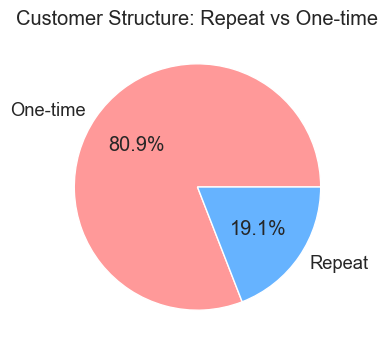

In [9]:
# === 2.1 客戶留存概況數據驗證 ===
# 使用 customer_orders 進行計算

# 1. 計算各類客戶數量
repeat_counts = customer_orders["repeat_customer"].value_counts()
repeat_props = customer_orders["repeat_customer"].value_counts(normalize=True)

print("=== 客戶留存概況 (Retention Overview) ===")
print(f"總客戶數: {len(customer_orders)}")
print(f"一次性客戶 (False): {repeat_counts[False]} ({repeat_props[False]:.2%})")
print(f"回頭客 (True):     {repeat_counts[True]} ({repeat_props[True]:.2%})")

# 圓餅圖預覽 Notebook 範例
import matplotlib.pyplot as plt
plt.figure(figsize=(4, 4))
plt.pie(repeat_counts, labels=["One-time", "Repeat"], autopct='%1.1f%%', colors=['#ff9999','#66b3ff'])
plt.title("Customer Structure: Repeat vs One-time")
plt.show()

=== 交叉表：回頭客狀態 vs 首購是否用券 ===


first_order_coupon_used,False,True
repeat_customer,,
False,73.13%,26.87%
True,44.49%,55.51%


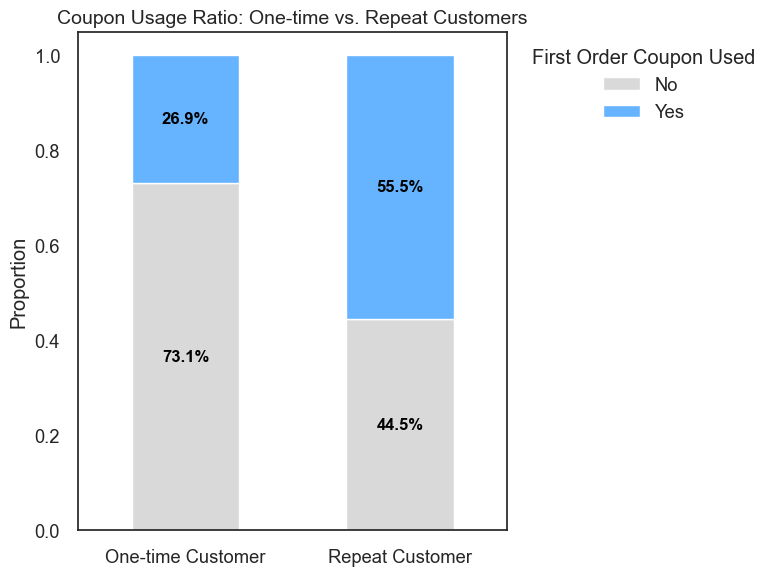

In [19]:
# === 2.2 首購優惠券 x 回購行為 交叉分析 ===

# 1. 建立交叉表
coupon_repeat_crosstab = pd.crosstab(
    index=customer_orders["repeat_customer"], 
    columns=customer_orders["first_order_coupon_used"],
    normalize='index' # 按列計算百分比
)

# 2. 為了畫圖好看，直接改 index 的名字
coupon_repeat_plot = coupon_repeat_crosstab.copy()
coupon_repeat_plot.index = ["One-time Customer", "Repeat Customer"]

print("=== 交叉表：回頭客狀態 vs 首購是否用券 ===")
display(coupon_repeat_crosstab.style.format("{:.2%}"))

# 3. 繪製堆疊長條圖
fig, ax = plt.subplots(figsize=(8, 6))

# 使用 Pandas 內建繪圖，但把物件存到 ax 以便後續加工
coupon_repeat_plot.plot(
    kind='bar', 
    stacked=True, 
    color=['#d9d9d9', '#66b3ff'], # 灰色: 沒用券, 藍色: 有用券
    ax=ax,
    edgecolor='white' # 加上白邊讓區塊分明
)

# 4. 重點：自動加上百分比標籤
# 這是 Matplotlib 3.4+ 的新功能，專門用來標示堆疊圖
for c in ax.containers:
    # 格式化標籤：變成百分比字串 (如 55.2%)
    labels = [f'{v.get_height():.1%}' for v in c]
    
    # 將標籤貼在柱子中間 (center)
    ax.bar_label(c, labels=labels, label_type='center', fontsize=12, color='black', weight='bold')

# 5. 設定圖表細節
plt.title("Coupon Usage Ratio: One-time vs. Repeat Customers", fontsize=14)
plt.xlabel("") # X軸標籤可以拿掉，因為刻度文字已經很清楚
plt.ylabel("Proportion")
plt.xticks(rotation=0) # 轉正文字

# 設定圖例 (移到圖表外側上方，避免擋住數據)
plt.legend(
    title="First Order Coupon Used", 
    labels=["No", "Yes"], 
    bbox_to_anchor=(1.02, 1), 
    loc='upper left'
)

plt.tight_layout()
plt.show()

In [20]:
# === 2.3 渠道品質分析 ===

# 針對 "首購渠道" 進行聚合分析
channel_quality = customer_orders.groupby("first_order_acquisition_channel").agg(
    customer_count=("customer_email", "count"),          # 客戶數
    repeat_rate=("repeat_customer", "mean"),             # 回頭客比例
    coupon_usage_rate=("first_order_coupon_used", "mean") # 首購用券比例
).reset_index()

# 過濾掉極小的渠道 (例如 < 10人) 以免干擾分析
channel_quality = channel_quality[channel_quality["customer_count"] > 10]

# 依照 "回頭客比例" 排序
channel_quality = channel_quality.sort_values(by="repeat_rate", ascending=False)

print("=== 各渠道客戶品質分析 (按回頭率排序) ===")
# 使用漸層色標示高低，讓洞察更明顯
display(channel_quality.style.background_gradient(cmap="Blues", subset=["repeat_rate", "coupon_usage_rate"])
                       .format({"repeat_rate": "{:.2%}", "coupon_usage_rate": "{:.2%}"}))

=== 各渠道客戶品質分析 (按回頭率排序) ===


,first_order_acquisition_channel,customer_count,repeat_rate,coupon_usage_rate
5,Newsletter,454,23.79%,85.68%
7,Shopping comparison,211,23.70%,28.91%
6,Referral,1081,21.37%,25.90%
10,Unknown,1218,20.77%,32.10%
3,Instagram,142,19.72%,25.35%
1,Facebook,1718,19.21%,23.34%
2,Google,1819,17.43%,32.82%
0,Direct,1815,16.47%,31.85%


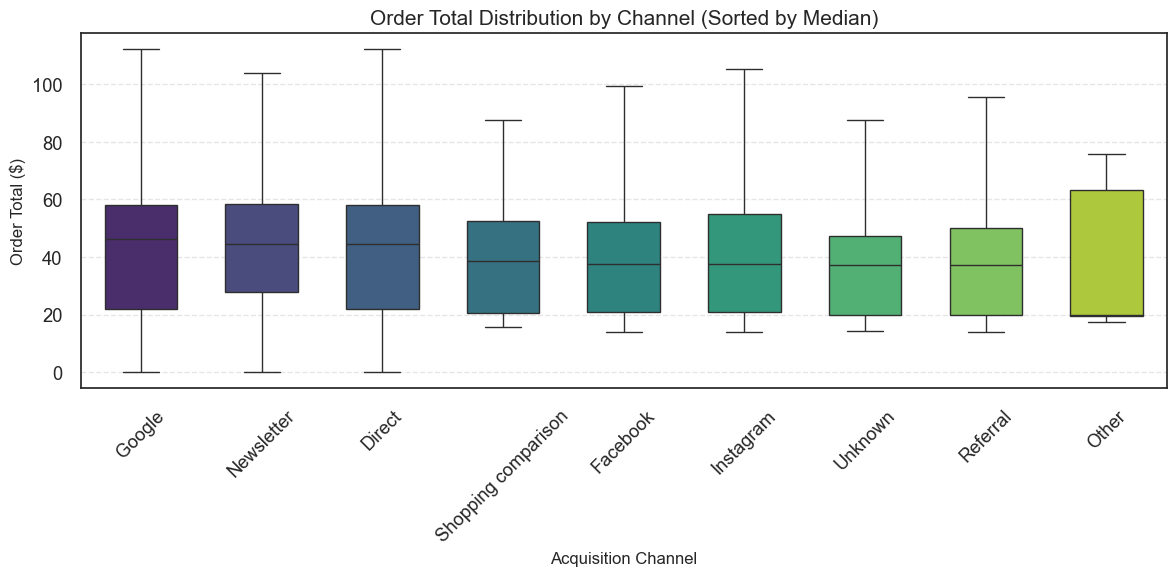

=== 訂單金額彙總：按渠道 (依照中位數排序) ===


,origin_grouped,median,mean,count
2,Google,46.20,49.57,2381
4,Newsletter,44.45,49.96,764
0,Direct,44.40,49.05,2373
7,Shopping comparison,38.70,41.31,249
1,Facebook,37.70,42.71,1990
3,Instagram,37.50,44.64,164
8,Unknown,37.30,39.71,1373
6,Referral,37.05,41.14,1240
5,Other,19.80,39.73,7


In [ ]:
# === 2.4 渠道 x 訂單金額 ===

# 1. 資料清洗：定義主要渠道 (Top 8)，其餘歸類為 "Other"
top_channels = orders["origin"].value_counts().nlargest(8).index
orders["origin_grouped"] = orders["origin"].apply(lambda x: x if x in top_channels else "Other")

# 2. 準備排序順序：先算好中位數，由大到小排序
# 這樣畫圖時，箱子就會乖乖排隊，不會亂跳
rank_order = orders.groupby("origin_grouped")["order_total"].median().sort_values(ascending=False).index

# 3. 繪製箱型圖 (Boxplot)
plt.figure(figsize=(12, 6))

sns.boxplot(
    data=orders, 
    x="origin_grouped", 
    y="order_total", 
    order=rank_order,     # <--- 指定排序
    palette="viridis",    # <--- 使用漸層色增強層次感
    showfliers=False,     # 隱藏極端值，專注看核心分布
    width=0.6             # 調整箱子寬度，讓畫面更精緻
)

plt.title("Order Total Distribution by Channel (Sorted by Median)", fontsize=15)
plt.xlabel("Acquisition Channel", fontsize=12)
plt.ylabel("Order Total ($)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5) # 加上網格線，方便對照金額

plt.tight_layout()
plt.show()

# 4. 統計摘要表
origin_summary = (
    orders
    .groupby("origin_grouped")["order_total"]
    .agg(["median", "mean", "count"])
    .reset_index()
    .sort_values("median", ascending=False)
)

print("=== 訂單金額彙總：按渠道 (依照中位數排序) ===")
# 使用 bar style 讓數字大小可視化
display(
    origin_summary.style
    .background_gradient(cmap='Blues', subset=["median", "mean"]) # <--- 改用這個：深淺色階
    .format("{:.2f}", subset=["median", "mean"])                  # 設定小數點 2 位
)

## 3. 基礎預測建模：回頭客可能性預測

In [ ]:
# === 3.2 資料準備與 PyCaret Setup ===
from pycaret.classification import *

# 1. 準備建模用的資料表 (只選取相關特徵)
# 我們直接使用之前建立好的 customer_orders
data_model = customer_orders[[
    "repeat_customer",                # Target
    "first_order_acquisition_channel", # Feature 1
    "first_order_coupon_used"          # Feature 2
]]

# 2. 初始化 PyCaret 環境
# session_id 固定為 123 以確保結果可重現
# fix_imbalance=True 用來解決 19% vs 81% 的資料不平衡問題
exp_clf = setup(
    data=data_model,
    target='repeat_customer',
    session_id=123,
    train_size=0.8,         # 80% 訓練, 20% Holdout
    fix_imbalance=True,     # 關鍵設定：處理類別不平衡
    verbose=False           # 設為 False 讓輸出簡潔一點
)

# 顯示 Setup 摘要
print("=== PyCaret Setup 完成 ===")
# pull() 可以抓出 setup 的 summary table
display(pull())

=== PyCaret Setup 完成 ===


,Description,Value
0,Session id,123
1,Target,repeat_customer
2,Target type,Binary
3,Original data shape,"(8464, 3)"
4,Transformed data shape,"(12649, 13)"
5,Transformed train set shape,"(10956, 13)"
6,Transformed test set shape,"(1693, 13)"
7,Categorical features,1
8,Preprocess,True
9,Imputation type,simple


In [ ]:
# === 3.3 模型比較與選擇 ===

# 1. 比較模型 (隱藏預設輸出)
best_model = compare_models(sort='AUC', exclude=['gbc', 'xgboost', 'lightgbm'], verbose=False)

# 2. 取得結果表
results_df = pull()

# 3. 定義要格式化的數字欄位 (避開 Model 名稱等文字欄位)
# 這些是 PyCaret 預設的指標欄位
numeric_cols = ['Accuracy', 'AUC', 'Recall', 'Prec.', 'F1', 'Kappa', 'MCC', 'TT (Sec)']

# 4. 套用樣式
print("=== 模型比較結果 (Sorted by AUC) ===")

dark_mode_style = (
    results_df.style
    # (A) 設定深色背景
    .set_properties(**{
        'background-color': '#2d2d2d',
        'color': '#e0e0e0',
        'border-color': '#555555'
    })
    # (B) 熱力圖 (只針對數字欄位)
    .background_gradient(cmap='viridis', subset=numeric_cols)
    # (C) 修正：只針對數字欄位設定小數點
    .format("{:.4f}", subset=numeric_cols)
)

display(dark_mode_style)

# 5. 建立最終模型
print("\n=== 建立最終模型: Logistic Regression ===")
lr_model = create_model('lr', verbose=False)

# 同樣修正最終模型的顯示
lr_results = pull()
# 檢查一下欄位，通常 create_model 的結果 index 是指標名稱，數值在欄位裡
# 這裡我們處理方式直接對所有 float 型態的欄位做格式化
display(
    lr_results.style
    .set_properties(**{'background-color': '#2d2d2d', 'color': '#e0e0e0'})
    .format("{:.4f}") # <--- 直接格式化所有數字欄位
)

=== 模型比較結果 (Sorted by AUC) ===


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.6995,0.6623,0.5615,0.3311,0.4165,0.2319,0.2466,0.0060
ada,Ada Boost Classifier,0.6995,0.6623,0.5615,0.3311,0.4165,0.2319,0.2466,0.0170
lda,Linear Discriminant Analysis,0.6995,0.6623,0.5615,0.3311,0.4165,0.2319,0.2466,0.0060
lr,Logistic Regression,0.6995,0.6621,0.5615,0.3311,0.4165,0.2319,0.2466,0.0070
rf,Random Forest Classifier,0.6995,0.6605,0.5615,0.3311,0.4165,0.2319,0.2466,0.0210
et,Extra Trees Classifier,0.6995,0.6602,0.5615,0.3311,0.4165,0.2319,0.2466,0.0190
dt,Decision Tree Classifier,0.6995,0.6600,0.5615,0.3311,0.4165,0.2319,0.2466,0.0060
nb,Naive Bayes,0.1914,0.6399,1.0000,0.1910,0.3208,0.0002,0.0056,0.0060
svm,SVM - Linear Kernel,0.6995,0.6381,0.5615,0.3311,0.4165,0.2319,0.2466,0.0070
knn,K Neighbors Classifier,0.7500,0.6146,0.1855,0.3353,0.1925,0.0830,0.0954,0.0290



=== 建立最終模型: Logistic Regression ===


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6755,0.6498,0.5308,0.3026,0.3855,0.1869,0.2005
1,0.7297,0.6669,0.6279,0.3750,0.4696,0.3033,0.3215
2,0.7105,0.6802,0.5891,0.3470,0.4368,0.2591,0.2755
3,0.7105,0.6688,0.5504,0.3397,0.4201,0.2413,0.2538
4,0.6809,0.6275,0.5349,0.3067,0.3898,0.1948,0.2086
5,0.7090,0.6895,0.5814,0.3440,0.4323,0.2536,0.2693
6,0.6942,0.6528,0.5581,0.3243,0.4103,0.2230,0.2379
7,0.7001,0.6352,0.5194,0.3221,0.3976,0.2124,0.2231
8,0.6942,0.6573,0.5231,0.3192,0.3965,0.2075,0.2188


## 3.4 模型效能與混淆矩陣

=== 1. 模型訓練效能 (Cross-Validation) ===


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.6923,0.6689,0.5294,0.3167,0.3963,0.2069,0.2192



=== 2. ROC Curve (ROC 曲線) ===


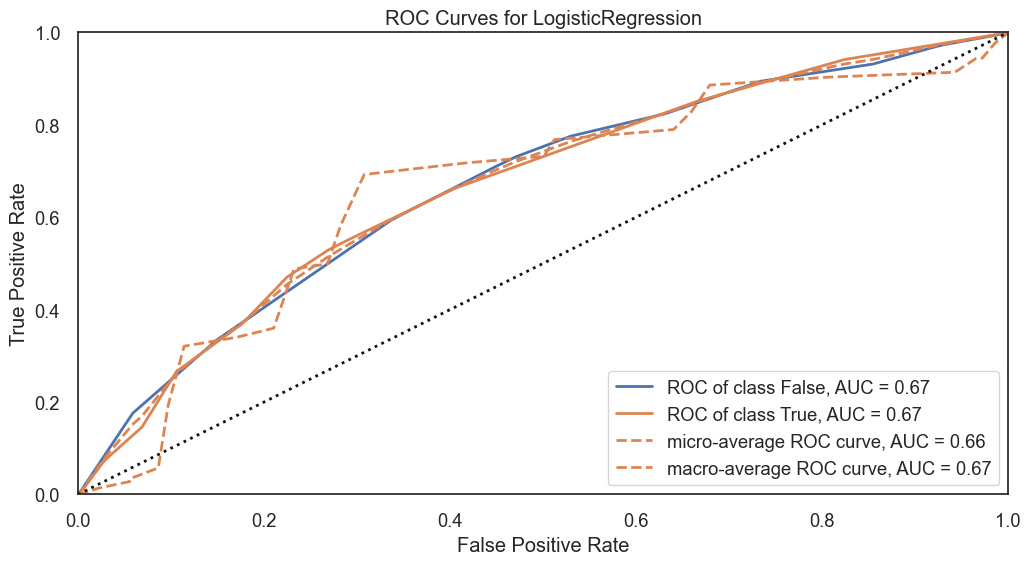


=== 3. Confusion Matrix (混淆矩陣) ===


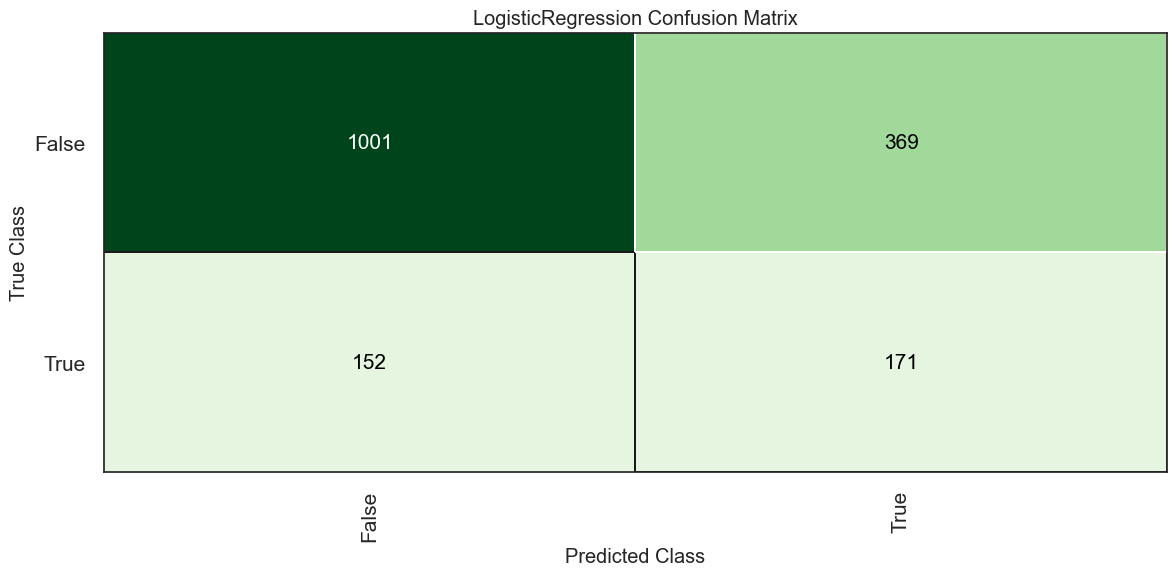


=== 4. Holdout Set 預測評估 ===


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.6923,0.6689,0.5294,0.3167,0.3963,0.2069,0.2192


In [47]:
# === 3.4 模型效能與評估圖表 ===

# 定義需要格式化的數字欄位
metric_cols = ['Accuracy', 'AUC', 'Recall', 'Prec.', 'F1', 'Kappa', 'MCC']

# --- 訓練集交叉驗證結果 (CV Results) ---
print("=== 1. 模型訓練效能 (Cross-Validation) ===")

# 重新抓取 create_model 的結果 (這是 10-fold CV 的平均值)
lr_results = pull() 

# 顯示美化表格 (深色模式 + 熱力圖)
display(
    lr_results.style
    .set_properties(**{
        'background-color': '#2d2d2d',
        'color': '#e0e0e0',
        'border-color': '#555555'
    })
    .format("{:.4f}", subset=[c for c in metric_cols if c in lr_results.columns])
    .background_gradient(cmap='viridis', subset=[c for c in metric_cols if c in lr_results.columns])
)

# --- Part 2: PyCaret 圖表 ---
print("\n=== 2. ROC Curve (ROC 曲線) ===")
plot_model(lr_model, plot='auc')

print("\n=== 3. Confusion Matrix (混淆矩陣) ===")
plot_model(lr_model, plot='confusion_matrix')

# --- Holdout Set 預測結果 ---
print("\n=== 4. Holdout Set 預測評估 ===")

# 使用模型預測保留的 20% 資料
holdout_pred = predict_model(lr_model, verbose=False) 

# 抓出評估結果
holdout_metrics = pull()

# 過濾掉表格中可能沒有的欄位
existing_cols = [c for c in metric_cols if c in holdout_metrics.columns]

# 顯示美化表格 (深色模式)
display(
    holdout_metrics.style
    .set_properties(**{
        'background-color': '#2d2d2d',
        'color': '#e0e0e0',
        'border-color': '#555555'
    })
    .format("{:.4f}", subset=existing_cols)
)

## 3.5 特徵重要性與模型係數解析

=== 特徵重要性排行 (Feature Importance) ===
圖表解讀：
1. 長條越長：代表這個特徵對預測結果的「影響力越大」。
2. 下圖僅顯示「強度」，不顯示方向（正/負）。具體的加分/扣分請看下方的係數表。


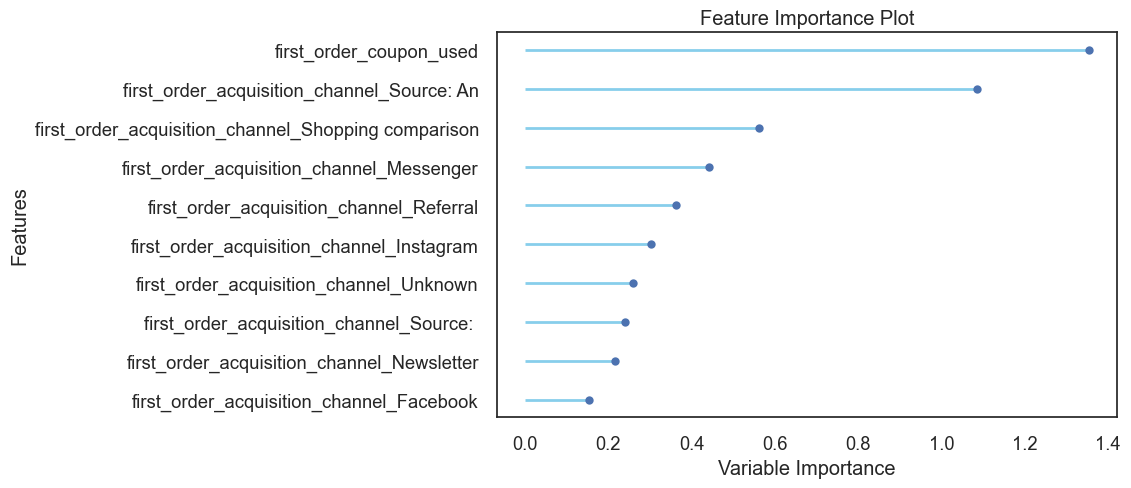


=== 詳細係數表 (確認加分或扣分) ===


,Feature,Coefficient
11,first_order_coupon_used,1.3533
9,first_order_acquisition_channel_Source: An,-1.0850
6,first_order_acquisition_channel_Shopping comparison,0.5619
8,first_order_acquisition_channel_Messenger,-0.4413
4,first_order_acquisition_channel_Referral,0.3623
3,first_order_acquisition_channel_Instagram,0.3021
0,first_order_acquisition_channel_Unknown,0.2600
10,first_order_acquisition_channel_Source:,-0.2394
7,first_order_acquisition_channel_Newsletter,-0.2151
5,first_order_acquisition_channel_Facebook,0.1534


In [53]:
# === 3.5 關鍵特徵解析 (圖表 + 方向驗證) ===

print("=== 特徵重要性排行 (Feature Importance) ===")
print("圖表解讀：")
print("1. 長條越長：代表這個特徵對預測結果的「影響力越大」。")
print("2. 下圖僅顯示「強度」，不顯示方向（正/負）。具體的加分/扣分請看下方的係數表。")
# 繪製 PyCaret 預設的特徵重要性圖
plot_model(lr_model, plot='feature')

# --- 提取係數表 (這是看加分/扣分的關鍵！) ---
try:
    # 1. 獲取特徵名稱 (優先從模型內部獲取，確保長度一致)
    if hasattr(lr_model, 'feature_names_in_'):
        feature_names = lr_model.feature_names_in_
    else:
        # 如果模型沒有存名稱，才嘗試從 PyCaret config 抓取
        feature_names = get_config('X_train').columns

    # 2. 獲取係數 (有些版本的 sklearn 係數是二維陣列，有些是一維，這裡做個兼容處理)
    if lr_model.coef_.ndim > 1:
        coefficients = lr_model.coef_[0]
    else:
        coefficients = lr_model.coef_

    # 3. 建立 DataFrame
    coefs = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    })
    
    # 加入絕對值以便排序 (找出影響力最大的)
    coefs['Importance'] = coefs['Coefficient'].abs()
    coefs = coefs.sort_values(by='Importance', ascending=False)
    
    # 定義樣式函數：正數顯紅(加分)，負數顯綠(扣分)
    def color_negative_red(val):
        # 紅色 (#d65f5f) 代表係數 > 0 (提升回頭率)
        # 綠色 (#5fba7d) 代表係數 < 0 (降低回頭率)
        color = '#d65f5f' if val > 0 else '#5fba7d' 
        return f'color: {color}; font-weight: bold'

    print("\n=== 詳細係數表 (確認加分或扣分) ===")
    
    # 顯示表格 (針對 Pandas 2.x 優化)
    display(
        coefs[['Feature', 'Coefficient']].head(10).style
        .map(color_negative_red, subset=['Coefficient'])  # Pandas 2.x 使用 .map 取代 .applymap
        .format("{:.4f}", subset=['Coefficient'])         # <--- 關鍵修復：指定只格式化係數欄位
    )
    
except Exception as e:
    print(f"無法提取係數: {e}")
    # 除錯資訊
    if 'feature_names' in locals(): print(f"特徵數量: {len(feature_names)}")
    if 'coefficients' in locals(): print(f"係數數量: {len(coefficients)}")

## 4. 建議與後續步驟

In [55]:
# === 4.3 模型分層行銷模擬 (策略落地) ===

# 1. 取得預測機率 (使用 predict_model 的 raw_score)
# 使用全部資料進行模擬，展示分層效果
# 注意：這裡假設 lr_model 和 data_model 已經在第 3 章建立好了
all_pred = predict_model(lr_model, data=data_model, verbose=False)

# 2. 定義分層邏輯 (依照預測機率切分)
# Top 20% = Tier 1 (High), Middle 40% = Tier 2 (Medium), Bottom 40% = Tier 3 (Low)
# 這種相對切分法比固定 0.5 切分法更適合商業應用
conditions = [
    (all_pred['prediction_score'] >= all_pred['prediction_score'].quantile(0.8)),
    (all_pred['prediction_score'] >= all_pred['prediction_score'].quantile(0.4))
]
choices = ['Tier 1 (High)', 'Tier 2 (Medium)']
all_pred['Customer_Tier'] = np.select(conditions, choices, default='Tier 3 (Low)')

# 3. 統計各層級的特徵 (驗證分層是否有意義)
tier_summary = all_pred.groupby('Customer_Tier').agg(
    Customer_Count=('repeat_customer', 'count'),
    Avg_Probability=('prediction_score', 'mean'),
    Actual_Repeat_Rate=('repeat_customer', 'mean'), # 驗證：這群人實際上真的比較常回頭嗎？
    Coupon_Usage_Rate=('first_order_coupon_used', 'mean')
).reset_index()

# 4. 加入行銷策略建議 (Actionable Insights)
strategy_map = {
    'Tier 1 (High)': '尊榮服務 (VIP) - 不主動給折扣，避免侵蝕毛利',
    'Tier 2 (Medium)': '強力促銷 (Push) - 投資重點區域，發送 Offer',
    'Tier 3 (Low)': '低成本維繫 (Email) - 廣撒網，避免漏掉潛在回頭客'
}
tier_summary['Marketing_Action'] = tier_summary['Customer_Tier'].map(strategy_map)

# 5. 顯示結果
print("=== 客戶分層行銷建議表 (Segmentation Strategy) ===")
display(
    tier_summary.style
    .background_gradient(cmap='Blues', subset=['Avg_Probability', 'Actual_Repeat_Rate'])
    .format({
        'Avg_Probability': '{:.2%}', 
        'Actual_Repeat_Rate': '{:.2%}',
        'Coupon_Usage_Rate': '{:.2%}'
    })
    .set_properties(**{'text-align': 'left'}) # 文字靠左對齊比較好讀
)

=== 客戶分層行銷建議表 (Segmentation Strategy) ===


,Customer_Tier,Customer_Count,Avg_Probability,Actual_Repeat_Rate,Coupon_Usage_Rate,Marketing_Action
0,Tier 1 (High),2473,69.45%,22.81%,47.27%,尊榮服務 (VIP) - 不主動給折扣，避免侵蝕毛利
1,Tier 2 (Medium),3714,64.96%,17.88%,31.64%,強力促銷 (Push) - 投資重點區域，發送 Offer
2,Tier 3 (Low),2277,59.09%,17.04%,17.26%,低成本維繫 (Email) - 廣撒網，避免漏掉潛在回頭客
